# Feature Engineering и углубленный анализ
  
**Цель:** улучшить качество аналитики за счёт создания дополнительных признаков, отражающих ключевые бизнес-характеристики товаров и поведения покупателей, а также выявить скрытые и нелинейные факторы, влияющие на выручку и объём продаж.  
  
**Источник данных:** data/flipkard_after_EDA.csv

## 1. Загрузка данных и подключение библиотек

In [2]:
#подключение библиотек
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#загрузка данных
df = pd.read_csv('../data/flipkard_after_EDA.csv')
df.head()

,product_id,product_name,category,brand,seller,seller_city,price,discount_percent,final_price,rating,...,warranty_months,color,size,return_policy_days,is_returnable,payment_modes,shipping_weight_g,product_score,seller_rating,revenue_m
0,FKP0000001,Adidas Ultra 664,Toys,Adidas,MegaStore,Hyderabad,35547.34,15,30215.24,1.9,...,36,Green,XL,30,True,"COD,CARD",3483.592454,6.78,3.28,1.994206
1,FKP0000002,LG Series 124,Fashion,LG,ValueKart,Mumbai,30693.79,10,27624.41,3.2,...,0,Grey,One Size,7,True,"UPI,CARD",2091.473835,50.78,3.42,74.668780
2,FKP0000003,Redmi Model 35,Beauty,Redmi,SmartDeals,Ahmedabad,51214.50,40,30728.70,4.4,...,12,Black,M,0,False,"COD,UPI,CARD",1242.770494,4.24,4.23,73.564508
3,FKP0000004,Sony Edition 769,Toys,Sony,UrbanRetails,Delhi,33168.49,30,23217.94,2.8,...,24,Black,L,0,False,"CARD,Wallet",3891.222716,1.38,3.45,40.213472
4,FKP0000005,Boat Prime 291,Home & Kitchen,Boat,RetailHub,Pune,14181.34,0,14181.34,3.7,...,0,Blue,Unknown,30,True,"CARD,Wallet",386.061014,79.27,4.90,65.858143


## 2. Проверяемые гипотезы на этапе углубленного анализа

1. **Ценовой сегмент и выручка:** медианная выручка увеличивается с повышением ценового сегмента (Low < Mid < High), что указывает на зависимость продаж от ценовой категории товара.
  
2. **Влияние рейтинга на продажи:** рейтинг товара не оказывает значимого линейного влияния на выручку, однако возможны скрытые эффекты, связанные с ценовым сегментом или сезонностью.
  
3. **Сезонность продаж:** продажи демонстрируют повторяющиеся пики в определённые месяцы, что может отражать сезонный спрос.

4. **Влияние быстрой доставки:** товары с коротким сроком доставки или более быстрой логистикой могут показывать более высокую выручку, особенно в пиковые сезоны.

## 3. Создание новых бизнес-признаков  

### 3.1 Эффективность продаж и ценовая политика 
**Цель:** Добавление метрик, отражающих эффективность продаж и ценовую политику 

In [4]:
#скидка в абсолютных значениях
df['discount_amount'] = df['price'] - df['final_price']

#относительная скидка
df['discount_ratio'] = df['discount_amount'] / df['price']

#доля проданных товаров 
df['sell_through_rate'] = df['units_sold'] / (df['units_sold'] + df['stock_available'])
df['sell_through_rate'] = df['sell_through_rate'].fillna(0)

### 3.2 Временные признаки 
  
**Цель:** проанализировать сезонность и влияние времени размещения товара на продажи

In [5]:
#преобразовываем даты
df['listing_date'] = pd.to_datetime(df['listing_date'])

In [6]:
df['listing_year'] = df['listing_date'].dt.year
df['listing_month'] = df['listing_date'].dt.month
df['listing_day'] = df['listing_date'].dt.day_name()

#считаем, сколько дней товар находится на витрине относительно последней даты в датасете (считаем ее текущей датой)
analysis_date = df['listing_date'].max()
df['days_on_market'] = (analysis_date - df['listing_date']).dt.days

### 3.3 Сегментация (биннинг)
  
**Цель:** выявить нелинейные зависимости 

In [7]:
#ценовые сегменты
df['price_segment'] = pd.qcut(df['price'], q=3, labels=['low', 'mid', 'high'])

#сегменты по рейтингу
def rating_group(r):
    if r < 3:
        return 'low'
    elif r < 4:
        return 'mid'
    else:
        return 'high'

df['rating_segment'] = df['rating'].apply(rating_group)

### 3.4 Логистические и сервисные признаки 
  
**Цель:** добвление признаков, отражающих удобство покупки и логистические характеристики товара

In [8]:
#быстрая доставка: 1, если доставка занимает 2 дня и меньше, иначе 0
df['fast_delivery'] = (df['delivery_days'] <= 2).astype(int)
#долгая гарантия: 1, если гарантия 12 месяцев и более, иначе 0
df['long_warranty'] = (df['warranty_months'] >= 12).astype(int)
#тяжелый товар: 1, если вес больше медианного по всем товарам, иначе 0
df['heavy_product'] = (df['weight_g'] > df['weight_g'].median()).astype(int)
#возвратный товар: преобразуем булево значение в 0 и 1
df['returnable'] = df['is_returnable'].astype(int)

### 3.5 Признаки доверия 
  
**Цель:** сформировать признаки доверия, отражающие уровень доверия со стороны покупателей

In [9]:
#высокий рейтинг товара: 1, если рейтинг 4.5 и выше, иначе 0
df['high_rating'] = (df['rating'] >= 4.5).astype(int)
#популярный товар: 1, если количество отзывов выше медианного, иначе 0
df['popular_product'] = (df['review_count'] > df['review_count'].median()).astype(int)
#надежный продавец: 1, если рейтинг продавца 4.5 и выше, иначе 0
df['trusted_seller'] = (df['seller_rating'] >= 4.5).astype(int)

### 3.6 Агрегированные признаки
  
**Цель:** добавить агрегированные признаки, отражающие среднии показатели на уровне категории и бренда


In [10]:
#средняя выручка по категориям
category_revenue = df.groupby('category')['revenue_m'].mean()
df['avg_revenue_by_category'] = df['category'].map(category_revenue)

#средние продажи по бренду
brand_sales = df.groupby('brand')['units_sold'].mean()
df['avg_units_sold_by_brand'] = df['brand'].map(brand_sales)

## 4. Углубленный анализ и визуализация

### 4.1 Выручка по ценовым сегментам 

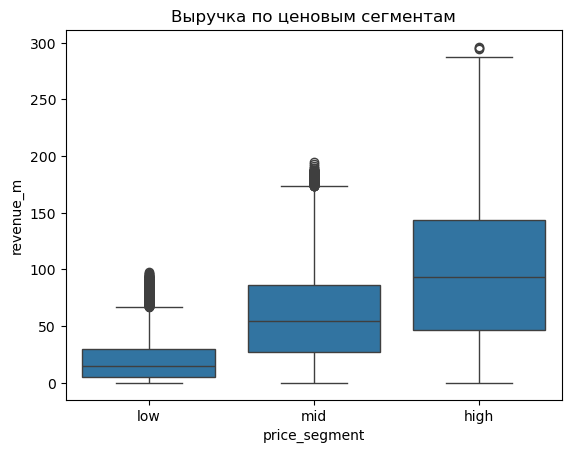

In [11]:
sns.boxplot(data=df, x='price_segment', y='revenue_m')
plt.title('Выручка по ценовым сегментам')
plt.savefig(f'../images/segments/price_segment.png', dpi=300, bbox_inches='tight')
plt.show()

Медианная выручка растет с увеличением ценового сегмента: low — стабильная, но низкая; mid — умеренная и относительно стабильная; high — высокая, но с широкой вариативностью. Для роста дохода рекомендуется фокус на high-сегменте, а low и mid поддерживают стабильный поток продаж.

### 4.2 Рейтинг и продажи

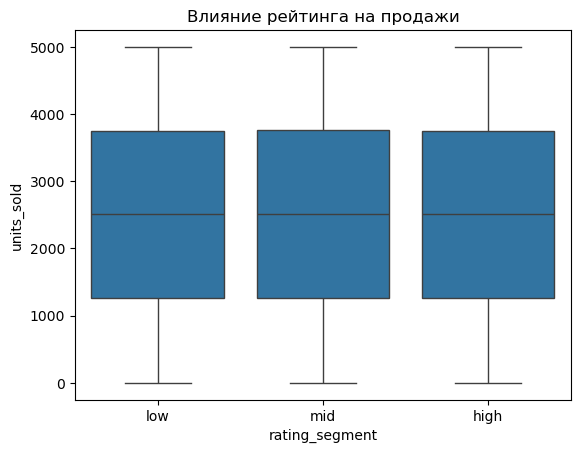

In [22]:
sns.boxplot(data=df, x='rating_segment', y='units_sold')
plt.title('Влияние рейтинга на продажи')
plt.savefig(f'../images/segments/rating_segment.png', dpi=300, bbox_inches='tight')
plt.show()

**Вывод:**  
Анализ boxplot по трём ценовым сегментам показал идентичные медианы и межквартильные размахи продаж. Это свидетельствует об отсутствии значимого влияния рейтинга на продажи.

### 4.3 Сезонность  

#### Общая сезонность продаж по всем годам

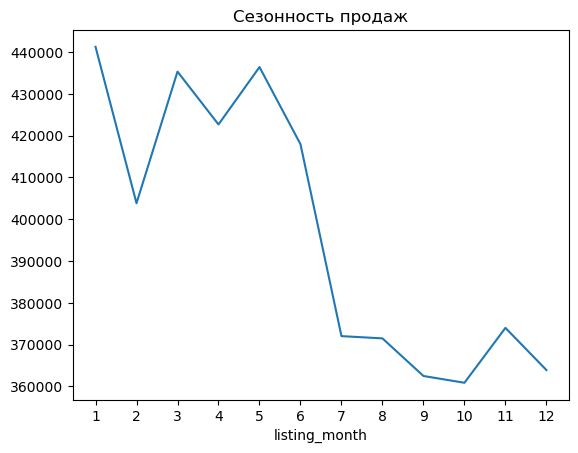

In [24]:
#агрегируем выручку по месяцам
monthly_revenue = df.groupby('listing_month')['revenue_m'].sum()

sns.lineplot(x=monthly_revenue.index, y=monthly_revenue.values)
plt.title('Сезонность продаж')
plt.xticks(range(1,13))
plt.savefig(f'../images/seasons/general.png', dpi=300, bbox_inches='tight')
plt.show()

**Вывод:**  
На графике наблюдаются выроженные пики продаж в месяцах 1,3,5. Это указывает на повторяющиеся периоды высокого спроса в начале года и весной

#### Сезонность продаж по годам с выдилением неполных лет

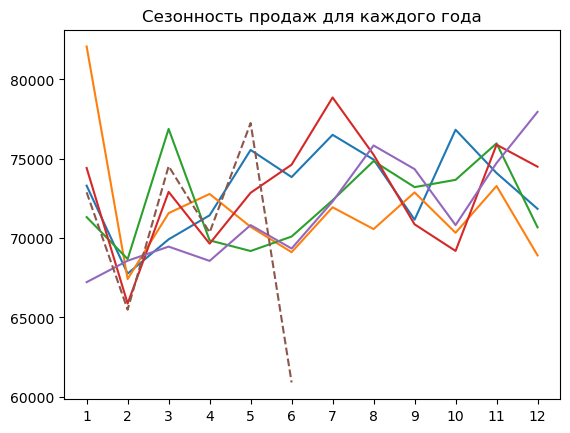

In [25]:
#агрегируем выручку по году и месяцу
season_revenue = df.groupby(['listing_year', 'listing_month'])['revenue_m'].sum().unstack(0)

#определяем сколько месяцев в году
months_per_year = df.groupby('listing_year')['listing_month'].nunique()
#определяем неполные годы
incomplete_year = months_per_year[months_per_year < 12].index.tolist()

for year in season_revenue.columns:
    linestyle = '--' if year in incomplete_year else '-'
    plt.plot(season_revenue.index, season_revenue[year], linestyle=linestyle)
plt.xticks(range(1,13))
plt.title('Сезонность продаж для каждого года')
plt.savefig(f'../images/seasons/all_years.png', dpi=300, bbox_inches='tight')
plt.show()

**Вывод:**  
- до 6 месяца тенденции по годам в целом совпадают с общей сезонностью  
- один год неполный, данные доступны только до июня  
- после 6 месяца наблюдаются отклонения, что подчеркивает важность проверки полноты данных  

#### Общая сезонность без учета неполных годов

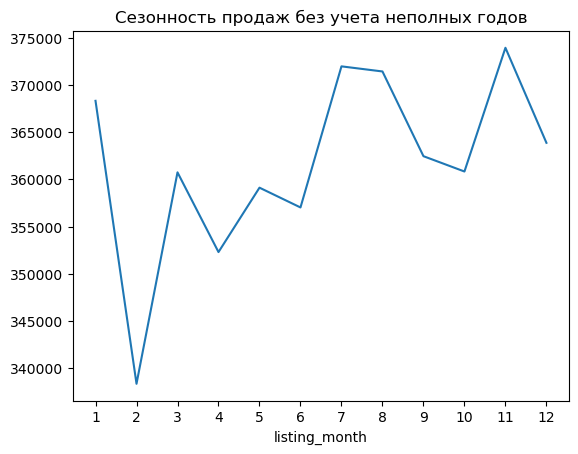

In [26]:
#выбираем только полные годы
full_years = months_per_year[months_per_year == 12].index
season_full = df[df['listing_year'].isin(full_years)].groupby('listing_month')['revenue_m'].sum()

sns.lineplot(x=season_full.index, y=season_full.values)
plt.title('Сезонность продаж без учета неполных годов')
plt.xticks(range(1,13))
plt.savefig(f'../images/seasons/general_full.png', dpi=300, bbox_inches='tight')
plt.show()

**Вывод:**  
После исключения неполных годов анализ данных выявил сезонные пики продаж в январе (1), марте (3), мае (5), июле (7) и ноябре (11), что указывает на цикличность спроса в течение года. При этом наиболее заметный спад наблюдается в феврале, что формирует характерный "провал" после январского максимума.

### 4.4 Быстрая доставка

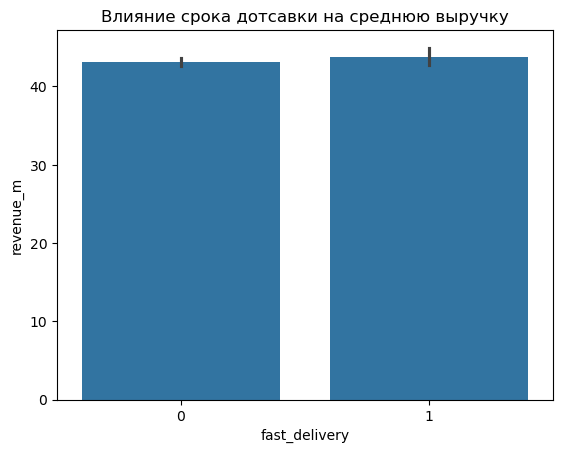

In [27]:
sns.barplot(data=df, x='fast_delivery', y='revenue_m', estimator=np.median)
plt.title('Влияние срока дотсавки на среднюю выручку')
plt.savefig(f'../images/segments/fast_delivery.png', dpi=300, bbox_inches='tight')
plt.show()

**Вывод:**  
Медианная выручка у товаров с быстрой доставкой немного выше, чем у товаров с обычной доставкой. Однако разница между группами незначительная, а доверительные интервалы пересекаются, что не позволяет уверенно говорить о статистически значимом эффекте.
  
Это может означать, что скорость доставки оказывает лишь слабое влияние на выручку, либо влияние маскируется другими факторами (цена, категория товара, спрос и т.д.). Для более точного вывода требуется проведение статистического теста.

### Мини-табличная аналитика

#### Гипотеза 1: медианная выручка увеличивается с повышением ценового сегмента

In [17]:
df.groupby('price_segment', observed=False)['revenue_m'].median()

price_segment
low     14.572830
mid     54.594497
high    92.911827
Name: revenue_m, dtype: float64

**Вывод:**
Медианные значения выручки существенно различаются между сегментами, что указывает на **явную зависимость продаж от ценового сегмента**. Продажи растут с повышением ценового сегмента: наибольшая медианная выручка наблюдается в премиум-сегменте (High), средняя — в среднем сегменте (Mid), а минимальная — в бюджетном сегменте (Low).  
Это подтверждает гипотезу о том, что **ценовой сегмент является важным фактором влияния на продажи**.

#### Гипотеза 2: рейтинг товара не оказывает значимого линейного влияния 

In [18]:
df.groupby('rating_segment')['revenue_m'].median()

rating_segment
high    42.887549
low     43.354778
mid     43.272247
Name: revenue_m, dtype: float64

**Вывод:** Медианные значения выручки практически одинаковы для всех сегментов рейтинга.

Это подтвержадет гипотезу о том, что рейтинг товара **не оказывает значимого линейного влияния на выручку**

#### Гипотеза 3: цикличность спроса

In [19]:
df[df['listing_year'].isin(full_years)].groupby('listing_month')['revenue_m'].sum()

listing_month
1     368344.929483
2     338309.209930
3     360752.490005
4     352290.514304
5     359126.745012
6     357026.126404
7     372004.266470
8     371462.030647
9     362469.146664
10    360842.602264
11    373976.158421
12    363887.453937
Name: revenue_m, dtype: float64

**Вывод:** В таблице видно несколько локальных пиков выручки: январь, март, май, июль, август и ноябрь. Остальные месяцы демонстрируют относительно низкие значения выручки.  

Это подтверждает гипотезу о **сезонности продаж**: выручка повторяющимися пиками увеличивается в определённые месяцы года, что может быть связано с сезонным спросом, праздничными периодами и маркетинговыми активностями.

#### Гипотеза 4: товары с быстрой логистикой могут показывать более высокую выручку

In [20]:
df.groupby('fast_delivery')['revenue_m'].median()

fast_delivery
0    43.074705
1    43.724081
Name: revenue_m, dtype: float64

**Вывод:** Медианные значения выручки практически совпадают, что указывает на **отсутствие заметного влияния скорости доставки на медианную выручку**.

# Общий вывод по резултатам углубленного анализа

1. **Влияние ценового сегмента:**  
   Медианная выручка растёт с увеличением ценового сегмента: Low — стабильная, но низкая; Mid — умеренная и относительно стабильная; High — высокая, с широкой вариативностью. Это подтверждает, что ценовой сегмент является важным фактором влияния на продажи. Для увеличения дохода рекомендуется фокусироваться на High-сегменте, при этом Low и Mid обеспечивают стабильный поток продаж.

2. **Влияние рейтинга:**  
   Анализ boxplot и медианных значений показал, что медианные значения выручки практически одинаковы для всех сегментов рейтинга. Это свидетельствует о том, что рейтинг товара **не оказывает значимого линейного влияния на выручку**.

3. **Сезонность продаж:**  
   Анализ выручки по месяцам выявил повторяющиеся локальные пики: январь, март, май, июль, август и ноябрь. Наиболее заметный спад наблюдается в феврале, что формирует характерный «провал» после январского максимума. Это подтверждает гипотезу о **сезонности продаж** и указывает на цикличность спроса в течение года.

4. **Влияние скорости доставки:**  
   Медианная выручка у товаров с быстрой доставкой немного выше, чем у товаров с обычной доставкой, однако разница незначительная. Это указывает на **отсутствие заметного влияния скорости доставки на медианную выручку**. Возможны скрытые эффекты других факторов (цена, категория товара, сезонный спрос), которые потребуют дальнейшей проверки на этапе моделирования.


**Вывод:**  
Данные этапа углубленного анализа показали, что ключевыми факторами, влияющими на выручку, являются **ценовой сегмент и сезонность**, тогда как рейтинг и скорость доставки не оказывают заметного прямого эффекта. Эти наблюдения формируют основу для дальнейшей проверки гипотез на этапе моделирования и позволяют выбрать информативные признаки для прогнозных моделей.

# Сформулированные гипотезы

1. **Гипотеза 1 (сезонность)**:  
После январского пика наблюдается наиболее резкий спад в феврале,   формирующий выраженный сезонный «провал». Выравнивание этого снижения может способствовать повышению годовой выручки.

2. **Гипотеза 2 (скорость доставки)**:  
Скорость доставки оказывает слабое влияние на выручку, либо её эффект скрыт другими факторами, такими как ценовой сегмент, категория товара или сезонный спрос. Для точного подтверждения требуется проведение статистической проверки.

# Сохранение данных

In [21]:
#сохраняем новый csv файл
df.to_csv('../data/flipkard_with_features.csv', index=False)